In [2]:
import numpy as np
import pandas as pd
import numpy as np
# from cvxpy import *
import datetime
from sklearn.linear_model import LinearRegression 

start_date = '2009-01-01'      
end_date = '2019-05-31'

m1 = M.instruments.v2(
    start_date=start_date,
    end_date=end_date,
    market='CN_STOCK_A',
    instrument_list=''
)

m7 = M.input_features.v1(
    features="""
beta_csi500_180_0
ta_mom_60_0
log(market_cap_0+0.0001)
west_eps_ftm_0/close_0
fs_net_income_0/market_cap_0
fs_eps_0/close_0
volatility_240_0
return_20
return_0
swing_volatility_240_0
fs_net_profit_qoq_0
fs_net_profit_yoy_0
fs_net_profit_0
west_netprofit_ftm_0
west_netprofit_ftm_0/market_cap_0
fs_operating_revenue_ttm_0/market_cap_0
fs_common_equity_0/market_cap_0
(fs_non_current_liabilities_0+market_cap_0)/market_cap_0
fs_total_liability_0/(fs_current_assets_0+fs_non_current_assets_0)
(fs_common_equity_0+fs_non_current_liabilities_0)/fs_common_equity_0
turn_0
"""
)

m8 = M.general_feature_extractor.v7(
    instruments=m1.data,
    features=m7.data,
    start_date='',
    end_date='',
    before_start_days=0
)

m9 = M.derived_feature_extractor.v3(
    input_data=m8.data,
    features=m7.data,
    date_col='date',
    instrument_col='instrument',
    drop_na=False,
    remove_extra_columns=False
)
 
# the material we need to build the factors are stored in Material DataFrame 
materials = m9.data.read_df()
materials = materials.set_index('date')

# materials.to_csv('D:/materialsStockData/materialsStockData.csv',index=True)

[2019-06-04 20:47:23.724034] INFO: bigquant: instruments.v2 开始运行..

[2019-06-04 20:47:23.779872] INFO: bigquant: 命中缓存

[2019-06-04 20:47:23.782274] INFO: bigquant: instruments.v2 运行完成[0.058237s].

[2019-06-04 20:47:23.788904] INFO: bigquant: input_features.v1 开始运行..

[2019-06-04 20:47:23.826905] INFO: bigquant: 命中缓存

[2019-06-04 20:47:23.828915] INFO: bigquant: input_features.v1 运行完成[0.04001s].

[2019-06-04 20:47:23.911449] INFO: bigquant: general_feature_extractor.v7 开始运行..

[2019-06-04 20:47:23.942847] INFO: bigquant: 命中缓存

[2019-06-04 20:47:23.945179] INFO: bigquant: general_feature_extractor.v7 运行完成[0.033723s].

[2019-06-04 20:47:23.960057] INFO: bigquant: derived_feature_extractor.v3 开始运行..

[2019-06-04 20:47:23.997208] INFO: bigquant: 命中缓存

[2019-06-04 20:47:23.999026] INFO: bigquant: derived_feature_extractor.v3 运行完成[0.038966s].

In [ ]:
'''
构建衍生因子
'''

In [3]:
# 构建十大类因子里面的所有小因子
# 流动性因子：stom,过去一个月日换手率之和的自然对数值;stoq,过去一个季度日换手率之和的自然对数值;stoa,过去一年日换手率之和的自然对数值
temporary_storage_dict = dict()
temporary_storage_dict['STOM'] = materials.groupby('instrument')['turn_0'].rolling(21).sum().apply(lambda x:np.log(x)).reset_index().set_index('date').rename(columns={'turn_0':'STOM'})
temporary_storage_dict['STOQ'] = temporary_storage_dict['STOM'].groupby('instrument').apply(lambda x:np.exp(x['STOM'])).rolling(3).mean().apply(lambda x:np.log(x)).reset_index().set_index('date').rename(columns={'STOM':'STOQ'})
temporary_storage_dict['STOA'] = temporary_storage_dict['STOM'].groupby('instrument').apply(lambda x:np.exp(x['STOM'])).rolling(12).mean().apply(lambda x:np.log(x)).reset_index().set_index('date').rename(columns={'STOM':'STOA'})

# 杠杆因子：mlev,市场杠杆,普通股市值+优先股账面值+长期负债账面值/普通股市值;dtoa,负债资产比;blev,账面杠杆,普通股账面值+优先股账面值+长期负债账面值/普通股账面值
temporary_storage_dict['MLEV'] = materials[['instrument','(fs_non_current_liabilities_0+market_cap_0)/market_cap_0']].rename(columns={'(fs_non_current_liabilities_0+market_cap_0)/market_cap_0':'MLEV'})
temporary_storage_dict['DTOA'] = materials[['instrument','fs_total_liability_0/(fs_current_assets_0+fs_non_current_assets_0)']].rename(columns={'fs_total_liability_0/(fs_current_assets_0+fs_non_current_assets_0)':'DTOA'})
temporary_storage_dict['BLEV'] = materials[['instrument','(fs_common_equity_0+fs_non_current_liabilities_0)/fs_common_equity_0']].rename(columns={'(fs_common_equity_0+fs_non_current_liabilities_0)/fs_common_equity_0':'BLEV'})

# 账面市值比因子：value,普通股账面值/普通股市值
temporary_storage_dict['Value'] = materials[['instrument','fs_common_equity_0/market_cap_0']].rename(columns={'fs_common_equity_0/market_cap_0':'Value'})

# 成长因子：growth,归母净利润同比增长率（有BUG,波动可能较大,估计不精确）
temporary_storage_dict['Growth'] = materials[['instrument','fs_net_profit_yoy_0']].rename(columns={'fs_net_profit_yoy_0':'Growth'})

# 盈利预期因子：epibs,cetop,分析师预期未来12月&历史12月盈利市值比;ETOP,历史12月现金流量市值比（有BUG）
temporary_storage_dict['EPIBS'] = materials[['instrument','west_eps_ftm_0/close_0']].rename(columns={'west_eps_ftm_0/close_0':'EPIBS'})
temporary_storage_dict['ETOP'] = materials[['instrument','fs_net_income_0/market_cap_0']].rename(columns={'fs_net_income_0/market_cap_0':'ETOP'})
temporary_storage_dict['CETOP'] = materials[['instrument','fs_eps_0/close_0']].rename(columns={'fs_eps_0/close_0':'CETOP'})

# 残差波动因子：dastd,过去12个月波动率;cmra,过去12个月对数超额收益率累加值序列的最大值减最小值;hsigma,CAPM模型过去12个月残差标准差（有BUG）
temporary_storage_dict['DASTD'] = materials[['instrument','volatility_240_0']].rename(columns={'volatility_240_0':'DASTD'})
temporary_storage_dict['GMRA'] = materials.groupby('instrument')['return_20'].rolling(12).apply(lambda x:np.log(1+np.max(x))-np.log(1+np.min(x))).reset_index().set_index('date').rename(columns={'return_20':'GMRA'})

# 市值因子：size,市值的自然对数
temporary_storage_dict['Size'] = materials[['instrument','log(market_cap_0+0.0001)']].rename(columns={'log(market_cap_0+0.0001)':'Size'})

# 动量因子：rstr,长期动量减去短期动量（有BUG）
temporary_storage_dict['Momentum'] = materials[['instrument','ta_mom_60_0']].rename(columns={'ta_mom_60_0':'Momentum'})

# 贝塔因子：beta,CAPM模型回归贝塔
temporary_storage_dict['Beta'] = materials[['instrument','beta_csi500_180_0']].rename(columns={'beta_csi500_180_0':'Beta'})

# 非线性市值 - 未构造完毕
temporary_storage_dict['Nlsize'] = temporary_storage_dict['Size'].copy().rename(columns={'Size':'Nlsize'})
temporary_storage_dict['Nlsize']['Nlsize'] = temporary_storage_dict['Size']['Size'].apply(lambda x: x**3)

In [4]:
instrument_list = list(set(materials['instrument'].tolist()))

In [96]:
# 残差波动因子构造part1 - dastd
def dastd(x):
    x['return_0'] = x['return_0'].apply(lambda x: (x-1)**2)
    ewma = pd.Series.ewm(x,halflife=42,min_periods=252).mean().rename(columns={'return_0':'dastd'})
    return ewma

dastd_save_df = pd.DataFrame()
for stock in instrument_list:
    tmp_dastd = dastd(materials[materials['instrument']==stock][['return_0','instrument']])
    dastd_save_df = pd.concat([dastd_save_df,tmp_dastd],axis=0)
temporary_storage_dict['dastd'] = dastd_save_df

KeyboardInterrupt: 

In [28]:
# 残差波动因子构造part2 - cmra
def cmra(x):
    tmp = pd.DataFrame(np.log(x))
    zseries = tmp.expanding().sum()
    zmax = np.max(zseries)
    zmin = np.min(zseries)
    return np.log((1+zmax)/(1+zmin))

cmra_save_df = pd.DataFrame()
for stock in instrument_list:
    tmp_cmra = materials[materials['instrument']==stock][['return_0','instrument']].rename(columns={'return_0':'cmra'})
    tmp_cmra['cmra'] = tmp_cmra['cmra'].rolling(252).apply(cmra)
    cmra_save_df = pd.concat([cmra_save_df,tmp_cmra],axis=0)
temporary_storage_dict['cmra'] = cmra_save_df

In [39]:
# 残差波动因子构造part3 - hsigma - 无市场收益率数据,不可跑

# 市场收益率序列,仅为例子! - 不是真正的市场指数收益率
MKT = (materials[materials['instrument']=='603999.SHA'][['return_0']]-1).rename(columns={'return_0':'MKT'})

def hsigma(x,window=252):
    '''
    自己写一个滚动回归函数,输入为N列df,y靠左X靠右,留下回归结果残差序列标准差
    返回一个series,长度与输入相同,残差标准差序列,前端缺失值用NaN填充
    '''
    tol_len = len(x)
    res_std_list = []
    for start_wind in range(tol_len-window+1):
        end_wind = start_wind+window
        tmp_df = x.iloc[start_wind:end_wind,]
        y = tmp_df.iloc[:,0]
        X = np.array(tmp_df.iloc[:,1::])
        reg = LinearRegression(fit_intercept=True)
        try:
            reg.fit(X,y)   # 将行业因子因子和市值因子对特定因子作回归
            res = y-reg.predict(X)
            res_std = np.std(res)
        except ValueError as e:   
            res_std = np.nan
        res_std_list.append(res_std)
    # 补充NaN
    res_series = [np.nan for i in range(window-1)]+res_std_list   
    return res_series

hsigma_save_df = pd.DataFrame()
for stock in instrument_list:
    tmp_hsigma = materials[materials['instrument']==stock][['return_0','instrument']].rename(columns={'return_0':'hsigma'})
    tmp_hsigma = tmp_hsigma.merge(MKT,how='inner',left_index=True,right_index=True) # MKT是市场收益率序列df
    tmp_hsigma['hsigma'] = hsigma(tmp_hsigma[['hsigma','MKT']])
    hsigma_save_df = pd.concat([hsigma_save_df,tmp_hsigma],axis=0)
temporary_storage_dict['hsigma'] = hsigma_save_df[['hsigma','instrument']]

,hsigma,instrument
date,,
2017-12-01,NaN,300195.SZA
2017-12-04,NaN,300195.SZA
2017-12-05,NaN,300195.SZA
2017-12-06,NaN,300195.SZA
2017-12-07,NaN,300195.SZA
2017-12-08,NaN,300195.SZA
2017-12-11,NaN,300195.SZA
2017-12-12,NaN,300195.SZA
2017-12-13,NaN,300195.SZA


In [5]:
# 因子:数据框 的字典拼接成一张表
for i in list(set(temporary_storage_dict.keys())):
    temporary_storage_dict[i] = temporary_storage_dict[i].reset_index()

initiate_factor_df  = temporary_storage_dict['STOM']  # 这里先取STOM因子数据
tmp_raw_factor_name = list(set(temporary_storage_dict.keys()).difference(['STOM']))
for i in tmp_raw_factor_name:
    initiate_factor_df = initiate_factor_df.merge(temporary_storage_dict[i], )

In [6]:
# 非线性市值 - 构造完毕
def Nlsize(df):
    tmp = df[['Size','Nlsize']]
    X = np.array(tmp[['Size']])
    y = tmp['Nlsize'].values
    reg = LinearRegression()
    try:
        reg.fit(X,y)   # 将行业因子因子和市值因子对特定因子作回归
        res = y-reg.predict(X.reshape(-1, 1))
        df['Nlsize'] = res
    except ValueError as e:   
        df['Nlsize'] = np.nan
    return df
initiate_factor_df = initiate_factor_df.groupby('date').apply(Nlsize)

In [ ]:
'''
去极值处理
'''

In [7]:
# 去极值处理（截面）
def winsorize(df):
    factors = set(df.columns).difference(['date', 'instrument'])
    for factor in factors:
        # 某个时间截面上全是NaN
        if df[df[factor].isnull()==True].shape[0] == len(df):
            continue
        median = np.median(df[factor])
        MAD = np.median(np.abs(df[factor] - median))
        df[factor][df[factor]>median+5*MAD] = median+5*MAD  # 盖帽处理偏离中位数5倍以上的数据
        df[factor][df[factor]<median-5*MAD] = median-5*MAD
    return df

# 截面数据去极值,返回日频因子数据
extrema_remove_df = initiate_factor_df.groupby('date').apply(winsorize)  

In [10]:
'''
数据转为月度,行业数据拼接,因子缺失值截面行业均值填充,行业、市值中性化处理和标准化处理
'''

'\n数据转为月度,行业数据拼接,因子缺失值截面行业均值填充,行业、市值中性化处理和标准化处理\n'

In [8]:
# 读取行业数据和市值数据,并月度化
ins = list(extrema_remove_df.instrument.unique())
industry_info = D.history_data(ins, start_date, end_date, ['industry_sw_level1','market_cap_float'])   
industry_info['market_cap_float'] = np.log10(industry_info['market_cap_float'])  # 对市值因子取对数

industry_df = industry_info[(industry_info.industry_sw_level1!=0)&(industry_info.industry_sw_level1!=-1)].set_index('date')  # 取出其中有行业分类的条目，如果行业划分是0或者-1就算了，代表无划分

industry_df = industry_df.groupby('instrument').apply(lambda x: x.resample('M', how='last'))  
industry_df.index = industry_df.index.droplevel(0)
industry_df.reset_index(inplace=True)

In [9]:
# 风格因子数据转换成月度,并与市值行业数据的拼接,并把行业因子转换成dummy数据 
extrema_remove_df.set_index('date', inplace=True)
extrema_remove_df = extrema_remove_df.groupby('instrument').apply(lambda x: x.resample('M', how='last'))  # pandas 处理时间序列数据，将原始数据转换为月末数据
extrema_remove_df.index = extrema_remove_df.index.droplevel(0) # 有多重index,丢弃股票代码index（来自groupby）
extrema_remove_df.reset_index(inplace=True)

extrema_remove_df = extrema_remove_df.merge(industry_df, on=['date', 'instrument']) # 风格因子数据和市值行业数据拼接

# 截面因子缺失值数据使用行业均值填充
extrema_remove_df = extrema_remove_df.groupby(['date', 'industry_sw_level1']).apply(lambda t: t.fillna(np.mean(t, axis=0)))
extrema_remove_df.reset_index(inplace=True, drop=True)

# 行业属性数据哑变量
dummy_industry_df = pd.get_dummies(extrema_remove_df['industry_sw_level1'], prefix='industry_prefix')   

# 哑变量与截面数据进行横向拼接
merge_df = pd.concat([extrema_remove_df, dummy_industry_df], axis=1).sort_values(['date', 'instrument'])  # 原始的行业因子那列应该还在

In [10]:
# 行业中性化处理和市值中性化处理 - 正交
def calcu_single_factor(df, factor):
    # 行业哑变量
    industry_factor = [i for i in df.columns if i[:15]=='industry_prefix']
    # 对市值因子和行业因子进行回归
    xvars = ['market_cap_float'] + industry_factor
    used_factors = xvars + [factor] + ['instrument']
    
    used_factors_df = df[used_factors]
    used_factors_df = used_factors_df[~used_factors_df.isnull().T.any().T]
    if len(used_factors_df) == 0:
        return None
    X = used_factors_df[xvars]
    y = used_factors_df[factor]
    reg = LinearRegression()
    try:
        reg.fit(X,y)   # 将行业因子因子和市值因子对特定因子作回归
        res = y-reg.predict(X)
        used_factors_df[factor] = res
    except ValueError as e:
        used_factors_df[factor] = np.nan 

    return used_factors_df[['instrument',factor]]

detail_style_factor = [m for m in initiate_factor_df.columns if m not in ['date','instrument','market_cap_float']]  

# 对风格因子进行市值中性化处理,共计16个风格因子
# 对每个因子,在时间截面上处理
factor_data_after_neutralize = pd.DataFrame(columns=['date','instrument'])
for factor in detail_style_factor: 
    result_temp = merge_df.groupby('date').apply(lambda x: calcu_single_factor(x, factor)).reset_index().drop('level_1',axis=1)
    factor_data_after_neutralize = factor_data_after_neutralize.merge(result_temp, on=['date', 'instrument'], how='outer') # 因为是拼接,每次都取并集,第一次相当于填充

# 标准化处理
def standardlize(x):
    return (x-x.mean())/x.std()
for factor in detail_style_factor:
    factor_data_after_neutralize[factor] = factor_data_after_neutralize.groupby('date')[factor].apply(standardlize)

# 用0值填充标准化后的缺失值 
factor_data_after_standard = factor_data_after_neutralize.fillna(0)

In [15]:
'''
获取股票价格数据
'''

'\n获取股票价格数据\n'

In [11]:
# 获取股票价格并月度化 - 从已经构造好的因子数据集获取时间以及标的信息
start = factor_data_after_standard.date.min().strftime('%Y-%m-%d')   
end = factor_data_after_standard.date.max().strftime('%Y-%m-%d')      
ins = list(set(factor_data_after_standard.instrument))    

price = DataSource('bar1d_CN_STOCK_A').read(instrument=ins, start_date=start, end_date=end, fields=['close'])    
price.rename(columns={'close':'price'}, inplace=True)
price = price.set_index('date').groupby('instrument').apply(lambda x: x.resample('M', how='last'))    
price.index = price.index.droplevel(0)
price.reset_index(inplace=True)

In [17]:
'''
数据透视表计算股票收益率与因子数据合并
'''

'\n数据透视表计算股票收益率与因子数据合并\n'

In [12]:
# 通过价格计算收益率并合成大类风格因子
tmp_factor = [m for m in merge_df.columns if m not in ['market_cap_float','industry_sw_level1']]
industry_prefix_factor = list(set(tmp_factor).difference(set(detail_style_factor)))  # industry_prefix_factor  是date instrument 和行业因子,共计30个因子

# 构建一个总的数据表, 合并行业因子和价格
monthly_style_and_industry_factor = factor_data_after_standard.merge(price, on=['date', 'instrument'], how='inner')
monthly_style_and_industry_factor = monthly_style_and_industry_factor.merge(merge_df[industry_prefix_factor], on=['date', 'instrument'], how='inner').set_index('date')  

# 计算出收益率 - 需要注意,月度收益率若为T~T+1期的收益,则标记时间为T,因为与因子对应的收益率数据是下一期收益
monthly_style_and_industry_factor.reset_index(inplace=True)

monthly_price_df = monthly_style_and_industry_factor.pivot_table(values='price',columns='instrument',index='date')
# monthly_style_and_industry_factor = monthly_style_and_industry_factor.merge(monthly_price_df.pct_change().shift(-1).unstack(
#                               ).to_frame('return').reset_index(),on=['date','instrument']) # 这里的shift(-1)很关键
monthly_style_and_industry_factor = monthly_style_and_industry_factor.merge(monthly_price_df.pct_change().shift(-1).unstack(
                              ).reset_index().rename(columns={0:'return'}),on=['date','instrument']) # 这里的shift(-1)很关键
monthly_style_and_industry_factor = monthly_style_and_industry_factor.dropna()

In [93]:
print(merge_df.columns,'\n')
print(factor_data_after_standard.columns)

Index(['date', 'instrument', 'STOM', 'Size', 'Beta', 'GMRA', 'Growth', 'BLEV',
       'STOQ', 'Momentum', 'ETOP', 'DTOA', 'DASTD', 'MLEV', 'Value', 'EPIBS',
       'STOA', 'CETOP', 'industry_sw_level1', 'market_cap_float',
       'industry_prefix_110000', 'industry_prefix_210000',
       'industry_prefix_220000', 'industry_prefix_230000',
       'industry_prefix_240000', 'industry_prefix_270000',
       'industry_prefix_280000', 'industry_prefix_330000',
       'industry_prefix_340000', 'industry_prefix_350000',
       'industry_prefix_360000', 'industry_prefix_370000',
       'industry_prefix_410000', 'industry_prefix_420000',
       'industry_prefix_430000', 'industry_prefix_450000',
       'industry_prefix_460000', 'industry_prefix_480000',
       'industry_prefix_490000', 'industry_prefix_510000',
       'industry_prefix_610000', 'industry_prefix_620000',
       'industry_prefix_630000', 'industry_prefix_640000',
       'industry_prefix_650000', 'industry_prefix_710000',
       'in

In [ ]:
'''
小类因子合并为大类因子 - 比较灵活
'''

In [13]:
# 小因子等权重合并成大因子, 这里未来可以采取IC_IR法
monthly_style_and_industry_factor['Volatility'] = (monthly_style_and_industry_factor['DASTD']+monthly_style_and_industry_factor['GMRA'])/2
# monthly_style_and_industry_factor['Volatility'] = monthly_style_and_industry_factor['dastd']
monthly_style_and_industry_factor['EarningYields'] = (monthly_style_and_industry_factor['EPIBS']+monthly_style_and_industry_factor['ETOP']+monthly_style_and_industry_factor['CETOP'])/3
monthly_style_and_industry_factor['Leverage'] = (monthly_style_and_industry_factor['MLEV']+monthly_style_and_industry_factor['BLEV']+monthly_style_and_industry_factor['DTOA'])/3
monthly_style_and_industry_factor['Liquidity'] = (monthly_style_and_industry_factor['STOM']+monthly_style_and_industry_factor['STOQ']+monthly_style_and_industry_factor['STOA'])/3
monthly_style_and_industry_factor.drop(['DASTD','GMRA','EPIBS','ETOP','CETOP','MLEV','BLEV','DTOA','STOM','STOQ','STOA'], axis=1, inplace=True)

In [58]:
monthly_style_and_industry_factor.columns

Index(['date', 'instrument', 'STOM', 'MLEV', 'Size', 'Momentum', 'EPIBS',
       'GMRA', 'ETOP', 'Nlsize', 'Beta', 'BLEV', 'dastd', 'Value', 'CETOP',
       'STOA', 'STOQ', 'Growth', 'DTOA', 'DASTD', 'price',
       'industry_prefix_490000', 'industry_prefix_710000',
       'industry_prefix_420000', 'industry_prefix_620000',
       'industry_prefix_430000', 'industry_prefix_510000',
       'industry_prefix_240000', 'industry_prefix_350000',
       'industry_prefix_370000', 'industry_prefix_460000',
       'industry_prefix_480000', 'industry_prefix_230000',
       'industry_prefix_450000', 'industry_prefix_110000',
       'industry_prefix_730000', 'industry_prefix_270000',
       'industry_prefix_410000', 'industry_prefix_640000',
       'industry_prefix_220000', 'industry_prefix_650000',
       'industry_prefix_210000', 'industry_prefix_360000',
       'industry_prefix_720000', 'industry_prefix_610000',
       'industry_prefix_340000', 'industry_prefix_330000',
       'industry_prefix_

In [ ]:
'''
计算股票特质收益率
'''

In [14]:
style_factor = ['Value','Growth','Size','Beta','Momentum','Volatility','EarningYields','Leverage','Liquidity','Nlsize']

In [15]:
# 在每个时间截面上,收益率对因子回归(这里包括十大风格因子和行业因子), 通过回归计算出每个股票的残差

def calcu_factor_specified_return(df):
    xvars = list(set(df.keys()).difference(['date','instrument','return','price']))
    X = df[xvars]
    y = df['return']
    reg = LinearRegression()
    try:
        reg.fit(X,y)
        res = y-reg.predict(X)
        df['specified_return'] = res
    except ValueError as e:
        df['specified_return'] = np.nan 

    return df

residual_ret = monthly_style_and_industry_factor.groupby('date').apply(calcu_factor_specified_return)
residual_ret = residual_ret[['instrument', 'date', 'specified_return']]
residual_ret = residual_ret.sort_values('date').set_index('date')

In [ ]:
'''
与Barra无关内容 - LSC
输入一个数据表：列至少包括因子+收益率（下期）+收盘价+股票名称+日期的面板堆叠数据表,已经完成缩尾、标准化、填补缺失值处理
输出IC、RankIC序列、多空组合收益序列
结果的日期是因子数据提取的日期
'''

In [14]:
analysis_used_df = monthly_style_and_industry_factor[style_factor+['date','instrument','return']]
# analysis_used_df = monthly_style_and_industry_factor[['date', 'instrument', 'STOM', 'MLEV', 'Size', 'Momentum', 'EPIBS','GMRA',
#                                                                        'ETOP', 'Nlsize', 'Beta', 'BLEV', 'dastd', 'Value', 'CETOP','STOA',
#                                                                        'STOQ', 'Growth', 'DTOA', 'DASTD', 'return']]
analysis_used_df_groupby_date = analysis_used_df.groupby('date')
analysis_factor_list = set(analysis_used_df.columns).difference(['date','instrument','return'])

## IC、RankIC序列计算,均值输出
def IC_get(df):
    corr_coef = df[[factor,'return']].corr().iloc[0,1]
    return pd.DataFrame([corr_coef],columns=['IC'+factor])

def RankIC_get(df):
    tmp_df = df[[factor,'return']]
    for col in [factor,'return']:
        tmp_df = tmp_df.sort_values(col)
        tmp_df[col] = range(1,len(tmp_df)+1)
    corr_coef = tmp_df.corr().iloc[0,1]
    return pd.DataFrame([corr_coef],columns=['RankIC'+factor])

IC_save_df = pd.DataFrame(columns=['date'])
for index_compute in [IC_get,RankIC_get]:
    for factor in analysis_factor_list:
        IC_save_df_tmp = analysis_used_df_groupby_date.apply(index_compute)
        IC_save_df_tmp.index = IC_save_df_tmp.index.droplevel(1)
        IC_save_df_tmp = IC_save_df_tmp.reset_index()
        IC_save_df = IC_save_df.merge(IC_save_df_tmp,on=['date'],how='outer')
print(pd.DataFrame(IC_save_df.mean(),columns=['ICmean']).sort_values('ICmean',ascending=True).head(10))
print(pd.DataFrame(IC_save_df.mean(),columns=['ICmean']).sort_values('ICmean',ascending=False).head(10))

## 因子首尾多空组合收益率计算,均值输出
Factor_portfolio_save_df = pd.DataFrame(columns=['date'])
def Factor_portfolio(df,N):
    tmp_df = df[[factor,'return']]
    tmp_df_L = tmp_df[tmp_df[factor] >= tmp_df[factor].quantile(1-1/N)]
    tmp_df_S = tmp_df[tmp_df[factor] <= tmp_df[factor].quantile(1/N)]
    L_return = tmp_df_L['return'].mean()
    S_return = tmp_df_S['return'].mean()
    LS_return = L_return - S_return
    return pd.DataFrame({'LS'+factor:[LS_return],'L'+factor:[L_return],'S'+factor:[S_return]})
for factor in analysis_factor_list:
    Factor_portfolio_save_df_tmp = analysis_used_df_groupby_date.apply(lambda x: Factor_portfolio(x,5))
    Factor_portfolio_save_df_tmp.index = Factor_portfolio_save_df_tmp.index.droplevel(1)
    Factor_portfolio_save_df_tmp = Factor_portfolio_save_df_tmp.reset_index()
    Factor_portfolio_save_df = Factor_portfolio_save_df.merge(Factor_portfolio_save_df_tmp,on=['date'],how='outer')
print(pd.DataFrame(Factor_portfolio_save_df.mean(),columns=['PortfolioRmean']).sort_values('PortfolioRmean',ascending=True).head(10))
print(pd.DataFrame(Factor_portfolio_save_df.mean(),columns=['PortfolioRmean']).sort_values('PortfolioRmean',ascending=False).head(10))

                    ICmean
RankICLiquidity  -0.106133
ICLiquidity      -0.087979
RankICVolatility -0.058573
RankICSize       -0.040310
ICVolatility     -0.031172
ICSize           -0.023537
RankICMomentum   -0.021796
RankICBeta       -0.019405
ICBeta           -0.014514
ICMomentum       -0.002984
                       ICmean
RankICNlsize         0.055935
ICNlsize             0.053276
RankICValue          0.049014
RankICEarningYields  0.033809
ICValue              0.029278
ICEarningYields      0.025957
RankICGrowth         0.022443
RankICLeverage       0.010008
ICLeverage           0.009247
ICGrowth             0.004499
              PortfolioRmean
LSLiquidity        -0.029416
LSVolatility       -0.010852
LSSize             -0.007092
LSBeta             -0.006139
LLiquidity          0.001431
LSMomentum          0.001734
LSGrowth            0.006723
LSLeverage          0.008622
SValue              0.009273
LVolatility         0.009374
                PortfolioRmean
LNlsize               0

In [ ]:
'''
与Barra无关内容 -LSC
计算多因子模型对未来收益截面解释力度 Rsquare
因子T期,收益T~T+1
'''

In [18]:
# 在每个时间截面上,收益率对因子回归(这里包括十大风格因子和行业因子), 通过回归计算出每个时间截面的回归Rsquare,得到序列
# style_factor = ['Value','Growth','Size','Beta','Momentum','Volatility','EarningYields','Leverage','Liquidity','Nlsize']

def calcu_model_rsquare(df):
    xvars = list(set(df.keys()).difference(['date','instrument','return','price']))
    X = df[xvars]
    y = df['return']
    reg = LinearRegression()
    try:
        reg.fit(X,y)
        score = reg.score(X,y)
    except ValueError as e:
        score = np.nan 

    return pd.DataFrame({'Rsquare':[score]})

rsquare_df = monthly_style_and_industry_factor.groupby('date').apply(calcu_model_rsquare)
rsquare_df.index = rsquare_df.index.droplevel(1)
# rsquare_df = rsquare_df.sort_values('date').set_index('date')

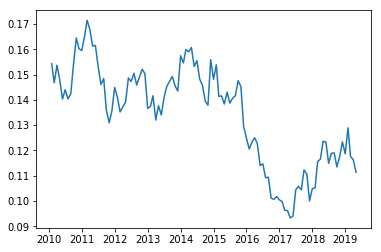

In [23]:
import matplotlib.pyplot as plt
plt.plot(rsquare_df.rolling(12).mean())
plt.show()

In [ ]:
'''
与Barra无关内容 - LSC
因子拥挤度计算
衡量因子被过度追踪的情况
数据均用expanding 标准化,故最开始几期参考意义不大
1.估值价差 - ln(Q1 B/P 中位数)/ (Q5 B/P 中位数)~标准化 + ln(Q1 S/P 中位数)/ (Q5 S/P 中位数)~标准化 + (Q1 E/P 中位数)-(Q5 E/P 中位数)~标准化
2.配对相关
3.因子波动
4.因子反转
'''

In [ ]:
'''
1.估值价差
ln(Q1 B/P 中位数)/(Q5 B/P 中位数)~标准化 + 
ln(Q1 S/P 中位数)/(Q5 S/P 中位数)~标准化 + 
(Q1 E/P 中位数)-(Q5 E/P 中位数)~标准化

Data
west_netprofit_ftm_0/market_cap_0 - E/P
fs_operating_revenue_ttm_0/market_cap_0 - S/P
fs_common_equity_0/market_cap_0 - B/P
'''

In [24]:
analysis_used_df = monthly_style_and_industry_factor[style_factor+['date','instrument','return']].reset_index()
materials_temp = materials.groupby('instrument').apply(lambda x: x.resample('M',how='last'))
materials_temp.index = materials_temp.index.droplevel(0)
materials_temp.reset_index(inplace=True)
analysis_used_df = analysis_used_df.merge(materials_temp,on=['date','instrument'],how='left')
analysis_factor_list = style_factor

In [62]:
def expanding_standarlize(df):
    '''
    输入具有多列的df,多列时间序列数据,index为日期'date',进行expanding标准化,均值用各列expanding均值,标准差用平均值
    '''
    df = df.copy()
    spread_name = df.columns.tolist()
    spread_mean_name = [i+'_mean' for i in spread_name]
    # 防止未来数据影响,时间序列标准化用expanding标准化
    value_spread_mean = df.expanding().mean()
    value_spread_mean.columns = spread_mean_name
    # 所除标准差是三子类指标平均标准差 - 保留了一定的相对差异
    value_spread_std = df.expanding().std()
    value_spread_avgstd = pd.DataFrame(value_spread_std.mean(axis=1),columns=['avgstd'])
    
    value_spread_df = df.merge(value_spread_mean,left_index=True,right_index=True).merge(value_spread_avgstd,left_index=True,right_index=True)
    # 标准化
    for name in spread_name:
        value_spread_df[name] = value_spread_df.apply(lambda x: (x[name]-x[name+'_mean'])/x['avgstd'],axis=1)
        
    return value_spread_df

In [63]:
def Crowding_value_spread(df,N):
    tmp_df = df.copy()
    tmp_df_L = tmp_df[tmp_df[factor] >= tmp_df[factor].quantile(1-1/N)]
    tmp_df_S = tmp_df[tmp_df[factor] <= tmp_df[factor].quantile(1/N)]
    Top_median_BP = tmp_df_L['fs_common_equity_0/market_cap_0'].median()
    Bottom_median_BP = tmp_df_S['fs_common_equity_0/market_cap_0'].median()
    Top_median_EP = tmp_df_L['west_netprofit_ftm_0/market_cap_0'].median()
    Bottom_median_EP = tmp_df_S['west_netprofit_ftm_0/market_cap_0'].median()
    Top_median_SP = tmp_df_L['fs_operating_revenue_ttm_0/market_cap_0'].median()
    Bottom_median_SP = tmp_df_S['fs_operating_revenue_ttm_0/market_cap_0'].median()
    BP_spread = np.log(Bottom_median_BP/Top_median_BP)
    EP_spread = Bottom_median_EP - Top_median_EP
    SP_spread = np.log(Bottom_median_SP/Top_median_SP)
    return pd.DataFrame({'BP_spread':[BP_spread],'EP_spread':[EP_spread],'SP_spread':[SP_spread]})

# 得到因子拥挤度子类
value_spread_save_df = pd.DataFrame()
for factor in analysis_factor_list:
    value_spread = analysis_used_df.groupby('date').apply(lambda x: Crowding_value_spread(x,5))
    value_spread.index = value_spread.index.droplevel(1)
    spread_name = value_spread.columns.tolist()

    # expanding标准化
    value_spread_df = expanding_standarlize(value_spread)
    
    # 各因子估值价差序列拼接
    value_spread_save_df = value_spread_save_df.merge(pd.DataFrame(value_spread_df[spread_name].mean(axis=1),columns=[factor+'_value_spread']),how='outer',left_index=True,right_index=True)
    
# 标准化供多拥挤度指标相加,均值使用expandingFactorSpecial,标准差统一用expandingFactorSpecialStd的均值
value_spread_save_df = expanding_standarlize(value_spread_save_df)

In [ ]:
'''
2.配对相关
Q1&Q5收益(截面)均值序列
Q1&Q5股票对相应收益均值序列计算trailing63天相关系数,各自求平均值
美股是两个相关系数再求和作为拥挤度代理变量之一,
A股应当改成Q5-Q1,衡量多头相对于尾部的异常同涨同跌,尾部无法做空不会出现同涨同跌。

Data
return_0 -> 1+r!

PS
数据透视表在这一部分可用,在月度时间截面上要获取trailing63天的收益率数据计算corr是一个单变量面板数据,使用pivot很方便
'''

In [20]:
# 日度的因子数据以及收益率数据供时间截面上正交
pair_col_used_df = pd.merge(initiate_factor_df, materials.reset_index(),on=['date','instrument'])

In [ ]:
# 首先计算特质收益率,对市场(常数项1)、规模、贝塔、残差波动率正交 - 未运行、耗时过长

def calcu_factor_specified_return(df):
    xvars = ['Size','Beta','Volatility']
    X = df[xvars]
    y = df['return_0']-1
    reg = LinearRegression(fit_intercept=True)
    try:
        reg.fit(X,y)
        res = y-reg.predict(X)
        df['specified_return'] = res
    except ValueError as e:
        df['specified_return'] = np.nan 

    return df

residual_ret_daily = pair_col_used_df.groupby('date').apply(calcu_factor_specified_return)
# residual_ret_daily = residual_ret_daily[['instrument', 'date', 'specified_return']]
# residual_ret_daily = residual_ret.sort_values('date').set_index('date')

In [38]:
# 用普通的日度收益率代替
col_pair_return_df = materials.copy()
# 因子数据所用df
col_pair_factor_df = monthly_style_and_industry_factor[style_factor+['instrument','date']].copy()

In [ ]:
# 样本期内全交易日列表
all_trade_day_list = materials.index.unique()

end_month_date_list = list(set(monthly_style_and_industry_factor.date))

# 计算出风格因子收益率 
cor_pair = pd.DataFrame()
for dt in end_month_date_list:
    
    # 对一个时间截面上,欲求所有因子的配对相关系数
    col_pair_factor_df_sub = col_pair_factor_df[col_pair_factor_df['date'] == dt]
    
    # trailing 63个 交易日
    dt_start = [date_ for date_ in all_trade_day_list if date_<=dt][-63]
    col_pair_return_df_sub = col_pair_return_df[(col_pair_return_df.index>=dt_start) & (col_pair_return_df.index<=dt)]
    col_pair_return_df_sub = col_pair_return_df_sub.reset_index()
    
    factor_cor_pair_dict = {}
    for factor in style_factor:
        
        L_list = col_pair_factor_df_sub[col_pair_factor_df_sub[factor] >= col_pair_factor_df_sub[factor].quantile(1-1/5)]['instrument'].unique().tolist()
        S_list = col_pair_factor_df_sub[col_pair_factor_df_sub[factor] <= col_pair_factor_df_sub[factor].quantile(1/5)]['instrument'].unique().tolist()
        
        # 计算多头以及空头组合个股与均值收益率的平均相关系数
        L_time_cross_return = col_pair_return_df_sub.pivot_table(index='date',columns='instrument',values='return_0')[L_list].apply(lambda x: x-1)
        L_time_cross_return['avg_return'] = L_time_cross_return.mean(axis=1)
        L_corr = L_time_cross_return.corr().sum()['avg_return']/len(L_list)
        S_time_cross_return = col_pair_return_df_sub.pivot_table(index='date',columns='instrument',values='return_0')[S_list].apply(lambda x: x-1)
        S_time_cross_return['avg_return'] = S_time_cross_return.mean(axis=1)
        S_corr = S_time_cross_return.corr().sum()['avg_return']/len(S_list)
        
        # 多头减空头作为当期该因子拥挤度
        factor_cor_pair = L_corr - S_corr
        
        factor_cor_pair_dict[factor] = factor_cor_pair
        
    cor_pair = cor_pair.merge(pd.DataFrame(factor_cor_pair_dict,index=[dt]),left_index=True,right_index=True,how='outer')
    
cor_pair = cor_pair.reset_index().rename(columns={'index':'date'}).sort_values('date').set_index('date')

In [ ]:
cor_pair

In [ ]:
'''
计算因子收益率
'''

In [121]:
# 对收益率序列做回归,这里包括九大风格因子和行业因子 
C = dict()
end_month_date = list(set(monthly_style_and_industry_factor.date))
end_month_date.sort()
 
# 全部因子，包括28个行业因子和9个大类风格因子
# all_factor_name = ['industry_prefix_630000','industry_prefix_110000','industry_prefix_410000','industry_prefix_620000','industry_prefix_610000','Leverage',
#  'industry_prefix_220000','industry_prefix_360000','industry_prefix_420000','industry_prefix_720000','Size',
#  'industry_prefix_350000','industry_prefix_330000','Value','industry_prefix_480000','Volatility','Liquidity','industry_prefix_640000','industry_prefix_280000',
#  'industry_prefix_340000','industry_prefix_650000','Growth','industry_prefix_710000','Momentum','industry_prefix_240000','industry_prefix_510000','Beta','industry_prefix_430000','industry_prefix_370000',
#  'industry_prefix_490000','industry_prefix_730000','EarningYields','industry_prefix_270000',
#  'industry_prefix_450000','industry_prefix_210000','industry_prefix_460000','industry_prefix_230000']

all_factor_name = list(set(monthly_style_and_industry_factor.columns).difference(['date', 'instrument','price','return']))
 
# 计算出风格因子收益率 
for dt in end_month_date:  
    temp = monthly_style_and_industry_factor[monthly_style_and_industry_factor['date'] == dt]  
    X = np.array(temp[all_factor_name])
    Y = temp['return'].values   
    reg = LinearRegression()
    try:
        reg.fit(X, Y)
        C[dt] = reg.coef_
    except ValueError as e:
        C[dt] = np.nan
        
common_factor_ret = pd.DataFrame.from_dict(C, orient='index')
common_factor_ret.columns = all_factor_name
common_factor_ret = common_factor_ret.sort_index()   

# 计算出风格因子和行业因子的风险协方差矩阵,默认配置参数为36个月
special_risk = residual_ret.groupby('instrument').apply(lambda x: x['specified_return'].fillna(0).rolling(36).var()).reset_index()  
common_risk = common_factor_ret.rolling(36).cov() # 风格因子和行业因子的风险协方差矩阵

In [ ]:
'''
计算基准在行业上的风险敞口
'''

In [132]:
# 基准在行业上的暴露 - 即基准的成分股权重每日按行业聚合
def get_bm_industry_exposure(start_date='2019-01-01', end_date='2019-03-08'):
    
    index = DataSource('index_element_weight').read(start_date=start_date, end_date=end_date)
    hs300_df = index[index['instrument_index'] == '000300.HIX'].copy() # 选出沪深300成分股

    industry_df = DataSource('industry_CN_STOCK_A').read(start_date=start_date, end_date=end_date, fields=['industry_sw_level1'])
    hs300_industry_df = pd.merge(hs300_df, industry_df, how='inner', on=['date', 'instrument']) # merge后成为沪深300的成分股每天的所属行业以及沪深300指数权重

    def get_weight(tmp):
        return tmp[['industry_sw_level1', 'weight']].groupby('industry_sw_level1').sum()

    bm_weight = hs300_industry_df.groupby(['date']).apply(get_weight).reset_index() # 聚合后是沪深300指数每一天在每个行业上的成分股权重和
    return bm_weight

bm_industry_exposure = get_bm_industry_exposure(start_date=start_date, end_date=end_date)


# 基准在风格因子上的暴露
def get_bm_component(start_date='2019-01-01', end_date='2019-03-08'):
    index = DataSource('index_element_weight').read(start_date=start_date, end_date=end_date)
    hs300_df = index[index['instrument_index'] == '000300.HIX']
    return hs300_df

bm_component = get_bm_component(start_date=start_date, end_date=end_date)

In [ ]:
'''
组合优化求解 - unsolved!
'''

In [149]:
point_date = '2019-01-21'  

# 每月最后一天 
natural_month_date = [dt for dt in end_month_date if dt<=pd.Timestamp(point_date)][-1]
natural_month_date = natural_month_date.strftime('%Y-%m-%d')

# 交易日
trading_calendar_date = [dt for dt in sorted(list(set(bm_component['date']))) if dt<=pd.Timestamp(point_date)][-1]  
trading_calendar_date = trading_calendar_date.strftime('%Y-%m-%d')

 
special_bm_industry_exposure = bm_industry_exposure[bm_industry_exposure['date'] == trading_calendar_date
                                               ][['industry_sw_level1','weight']].set_index('industry_sw_level1')

# 组合优化
special_risk = special_risk.dropna()
instrument_name = list(set(special_risk.instrument[special_risk['date'] == natural_month_date]))   

n = len(instrument_name) # 股票数量
m = len(common_factor_ret.columns) # 因子数量,包含风格因子和行业因子
 
mu = monthly_price_df[list(set(monthly_price_df.columns).intersection(instrument_name))
                     ].pct_change().fillna(0).rolling(36).mean().ix[natural_month_date]

mu.sort_index(inplace=True) # 将mu按股票顺序排序
 
mu = np.array(mu)

# 计算共同风险因子协方差矩阵
sigma_tilde = np.array(common_risk.ix[natural_month_date, :])
 
# 计算特征因子协方差矩阵
d = np.diag(special_risk[special_risk['date'] == natural_month_date].set_index('instrument')['specified_return'].sort_index().values)
 
# 下面我们计算因子在股票上的载荷
special_factor_df = monthly_style_and_industry_factor[monthly_style_and_industry_factor['date'] == natural_month_date] 
F1 = special_factor_df
F1 = F1.set_index('instrument')
F1 = F1.ix[instrument_name, :]
F1 = F1.reset_index()
F1 = F1.sort_values('instrument')
F = np.array(F1[all_factor_name])
 
w = Variable(n)  # 权重, 形如（3525 ,1）
gamma = Parameter(nonneg=True) # 风险厌恶系数 
Lmax = Parameter() # 杠杆
industry_factor = [i for i in F1.columns if i[:15] == 'industry_prefix']  

right_bm_weight = pd.DataFrame(special_bm_industry_exposure, index= [int(i[-6:]) for i in industry_factor] )
h = right_bm_weight.weight/100 
special_bm_component = bm_component[bm_component['date'] == trading_calendar_date]
w_b = list(pd.DataFrame(special_bm_component.set_index('instrument') ,index=instrument_name).fillna(0)['weight']/100)

# 好像暂时不需要这个
special_style_factor_df = special_factor_df[['date','instrument','Value',
                                     'Growth','Size','Beta','Momentum','Volatility','EarningYields','Leverage','Liquidity']]
benchmark_factor_df = special_style_factor_df[special_style_factor_df['instrument'].isin(list(special_bm_component.instrument))]

tmp_merge_df = benchmark_factor_df.merge(special_bm_component, how='inner', on='instrument')
tmp_merge_df['weight'] = tmp_merge_df['weight'] / 100

for f in style_factor:
    tmp_merge_df[f] = tmp_merge_df[f] * tmp_merge_df['weight']

factor_risk_exp = np.array(tmp_merge_df[style_factor].sum())

# 行业中性
H = np.array(F1[industry_factor])
h = np.array(h)   
h = np.array([round(i, 10) for i in h]) # 精度控制

# 权重归一化
deviate = h.sum()-1
if deviate > 0 :
    h[h.argmax()] = h[h.argmax()] - np.abs(deviate)
elif deviate < 0:
    h[h.argmin()] = h[h.argmin()] + np.abs(deviate)
assert h.sum() == 1, 'WARING:权重之和不为1！'

# 风格中性
w_b = np.array(w_b)

n_factor = len(style_factor)  # 风格因子数量
X = np.array(F1[style_factor])   # 全部股票在风格因子上的暴露,格式形如（3000，3）

ret = mu.T*w  # 收益
risk = quad_form(w, F.dot(sigma_tilde).dot(F.T) + d)

NameError: name 'Variable' is not defined

In [ ]:
#  组合优化   
t0 = datetime.datetime.now() 

# 确定优化目标，目前支持最大化收益、最小化风险、最大化风险调整收益
target = 'maximize_risk_adjusted_return'
 
if target == 'maximize_return':
    _obj = Maximize(ret)
elif target == 'minimize_risk':
    _obj =  -1 * Maximize(gamma*risk)
elif target == 'maximize_risk_adjusted_return':
    _obj = Maximize(ret - gamma*risk)

print('优化目标为： ', target)

constraint = [sum(w) == 1,   
                w >= 0,
                w <= 0.1,     
                w.T * H == h.T,
                (w.T-w_b.T) * X == np.zeros(len(style_factor))  
               ]

prob = Problem(_obj, constraint)
print("prob is DCP:",  prob.is_dcp()) # Problem must follow DCP rules.
Lmax.value = 1  
gamma.value = 0.1

try:
    prob.solve()
except Exception as e:
    print(e)

print("optimal value with OSQP:", prob.value)
print(prob.status)  

In [ ]:
'''
验证优化结果
'''

In [ ]:
print('最大权重数值为： ', w.value.max(), '\n')
print('最小权重数值为： ', w.value.min(), '\n')
print('权重之和为： ', w.value.sum(), '\n')

portfolio_industry_risk = np.reshape(w.value.T, (d.shape[0], 1)).T.dot(H)

base_info_industry_sw = DataSource('basic_info_IndustrySw').read(start_date=start_date, end_date=end_date)
one_level_industry_info = base_info_industry_sw[base_info_industry_sw.industry_sw_level == 1]
industry_map = dict(zip(one_level_industry_info['code'], one_level_industry_info['name']))

T.plot(pd.DataFrame({'benchmark': h.T.tolist(), 'portfolio': portfolio_industry_risk.tolist()[0]},
                    index= [industry_map[i[-6:]] for i in industry_factor]
                   ), chart_type='column', title='行业风险敞口暴露')

portfolio_factor_risk = (w.value.T-w_b.T).dot(X).tolist()
portfolio_factor_risk = w.value.T.dot(X).tolist()
benchmark_factor_risk =  w_b.T.dot(X).tolist()
T.plot(pd.DataFrame({'benchmark': benchmark_factor_risk , 'portfolio': portfolio_factor_risk}, index=style_factor
                   ), chart_type='column', title='因子风险敞口暴露')

print('optimal run cost:', (datetime.datetime.now() - t0).seconds) 

In [ ]:
modify_style_factor_exposure = np.zeros(len(style_factor))
modify_style_factor_exposure[0] = 0.2 
constraint = [sum(w) == 1,   
                w >= 0,
                w <= 0.1,     
                w.T * H == h.T,
                (w.T-w_b.T) * X == modify_style_factor_exposure
               ]

prob = Problem(_obj, constraint)
print("prob is DCP:",  prob.is_dcp()) # Problem must follow DCP rules.
Lmax.value = 1  
gamma.value = 0.1

try:
    prob.solve()
except Exception as e:
    print(e)

print("optimal value with OSQP:", prob.value)
print(prob.status)  

print('最大权重数值为： ', w.value.max(), '\n')
print('最小权重数值为： ', w.value.min(), '\n')
print('权重之和为： ', w.value.sum(), '\n')

portfolio_industry_risk = np.reshape(w.value.T, (d.shape[0], 1)).T.dot(H)

base_info_industry_sw = DataSource('basic_info_IndustrySw').read(start_date=start_date, end_date=end_date)
one_level_industry_info = base_info_industry_sw[base_info_industry_sw.industry_sw_level == 1]
industry_map = dict(zip(one_level_industry_info['code'], one_level_industry_info['name']))

T.plot(pd.DataFrame({'benchmark': h.T.tolist(), 'portfolio': portfolio_industry_risk.tolist()[0]},
                    index= [industry_map[i[-6:]] for i in industry_factor]
                   ), chart_type='column', title='行业风险敞口暴露')

portfolio_factor_risk = (w.value.T-w_b.T).dot(X).tolist()
portfolio_factor_risk = w.value.T.dot(X).tolist()
benchmark_factor_risk =  w_b.T.dot(X).tolist()
T.plot(pd.DataFrame({'benchmark': benchmark_factor_risk , 'portfolio': portfolio_factor_risk}, index=style_factor
                   ), chart_type='column', title='因子风险敞口暴露')

print('optimal run cost:', (datetime.datetime.now() - t0).seconds) 